# Machine Learning Hyperparameter Search (from Grid Search to SKOPT)
This is the Jupyter (IPython) notebook support for the Lisbon Data Science meetup of 2016/10/19, held at Startup Lisboa, Portugal. Link to the Meetup [here](http://www.meetup.com/Lisbon-Open-Data-Meetup/events/234758716/?_af=event&_af_eid=234758716&https=off).

### Introduction
An important part of using any machine learning algorithm (such as Logistic Regression or Random Forests) is tuning the hyper parameters. 

Tools such as scikit's **Grid-Search** and **Randomized Search** have greatly improved the ability to use CPU instead of sweat and tears to tune over large hyperparameter spaces. 

More recently, a new library has appeared - **Scikit-Optimize** - which allows us to use Bayesian Optimization (among other things) to help find good hyperparameters with less computation resources.  

---
**Contents**:
- Grid-Search CV
- Randomized Search CV
- Scikit-Optimize (SKOPT)

---
**Pre-requisites**:
- Some Python programming language background
- Machine Learning (supervised learning) models such as Random Forests
- Some exposure to Pandas, Numpy and Scikit-learn
- Motivation to have the best running classifier in the room

---
**Required Python lybraries** (latest versions if possible, you can easily install them with ***pip***)
- sklearn
- skopt
- pandas
- numpy
- scipy
- matplotlib

---  
Presenter: Hugo Lopes ([LinkedIn](https://linkedin.com/in/hugodlopes))  
Contact: hjdlopes@gmail.com

# Initializations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

import pandas as pd 
import numpy as np
from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

from skopt import gp_minimize

In [2]:
np.random.seed(seed=1)
results = {}

## Load Data
Go to [Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/data) (you need to be registered at Kaggle to download the data, if you're not, now it is the best time to do it :) ). Download the [*cs-training*](https://www.kaggle.com/c/GiveMeSomeCredit/download/cs-training.csv) (.csv (7.21 mb)) and place it in the same folder of this notebook.

In [3]:
data = pd.read_csv('cs-training.csv', index_col=0)

Let's check the structure of the data, now without NaN.

In [4]:
data.head(8)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0


Let's perform a fast and simple way to eliminate missing data by just dropping the rows with NaN. There are other methods to avoid wasting these rows, but it is out of the scope of this notebook.

In [5]:
print('Number of entries without NaN:')
print('---------------------------')
print(data.count())
data.dropna(inplace=True)

Number of entries without NaN:
---------------------------
SeriousDlqin2yrs                        150000
RevolvingUtilizationOfUnsecuredLines    150000
age                                     150000
NumberOfTime30-59DaysPastDueNotWorse    150000
DebtRatio                               150000
MonthlyIncome                           120269
NumberOfOpenCreditLinesAndLoans         150000
NumberOfTimes90DaysLate                 150000
NumberRealEstateLoansOrLines            150000
NumberOfTime60-89DaysPastDueNotWorse    150000
NumberOfDependents                      146076
dtype: int64


Now it is time to select the **target** (*y*, the first column) and **features** (*X*, the remaining columns). Note, we will perform binary classification so target is either 0 or 1.

Let us also **reduce the size of the dataset to 10000 rows (clients)** so that we can perform computations live.

In [6]:
# Get target column
y = data['SeriousDlqin2yrs']

# Get features columns
X = data.ix[:, 1:]

# Shuffle data and reduce dataset
idx = np.random.permutation(y.size)
X = X.iloc[idx]
X = X.iloc[:10000]
y = y.iloc[idx]
y = y.iloc[:10000]

print('Number of features (columns):', X.shape[1])
print('Number of loans (rows):', X.shape[0])

Number of features (columns): 10
Number of loans (rows): 10000


### Train-Test Split
Before we construct our model, let's divide the data into a **training dataset** (80 percent of the data) and a **test dataset** (20 percent of the data). We will train the classifier on the training dataset, and then evaluate the performance of our classifier with the test dataset. 

This is very useful to check if we are **overfitting** our training data, i.e., getting very good results within the training dataset and bad results with our testing dataset.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Making a First Prediction (with classifier's default configuration)
Let's make use of the [**Random Forest Classifier**](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (available in [scikit-learn](http://scikit-learn.org/stable/)).  

First, let's train it with the default configuration, then evaluate its performance on the test data:

In [9]:
clf = RandomForestClassifier(n_jobs=-1, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

From the output above we can check the configuration of the default Random Forests, such as the number of trees in the forest, *n_estimators=10*. So, with the created and trained classifier, let's check the **ROC AUC** on the given test data.

In [10]:
#results['Default'] = clf.score(X_test, y_test)
results['Default'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print('Test ROC AUC: %.4f' % results['Default'])

Test ROC AUC: 0.7907


# Tuning our Classifier: Grid-Search Cross-Validation
As scikit-learn defines it, [**GridSearchCV**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) is: *Exhaustive search over specified parameter values for an estimator.*  
The user defines a set of values for the classifier hyperparameters. Then, the GridSearchCV implements a “fit” and a “score” method. The evaluation is performed with Cross-Validation.

#### 1. Create Cross-Validation (CV) Folds
This [**StratifiedKFold**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) cross-validation object is a variation of KFold that returns stratified folds, ie., the folds are made by preserving the percentage of samples for each class (stratification is generally a better scheme, both in terms of bias and variance).

In [14]:
skfold_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

#### 2. Fixed Parameters
Secondly, let us define some parameters that we won't vary in our Random Forest ([click here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for full definition of its hyperparameters):
- n_jobs=-1, to use all cores
- random_state=1, so that we can re-run experiements with same results later
- n_estimators=50, the number of trees in the forest, usually the higher the better (so does not make much sense to optimize this...). 50 is not a high number for this experiment, but the higher the value is, the more computational resources we'll need.

In [15]:
# Fixed parameters
params_fixed = {
    'n_jobs': -1,
    'random_state': 1,
    'n_estimators': 100
}
# Initialize Random Forest model with the fixed parameters
clf = RandomForestClassifier(**params_fixed)

#### 3. Scoring metric
Now, we have to decide our **scoring metric** to evaluate the performance of our classifier. Some examples are *accuracy*, *mean_squared_error*, *roc_auc*.

In [16]:
#score_metric = 'accuracy'
score_metric = 'roc_auc'

### The Grid-Search CV
The Random Forest Classifier has a bunch of hyperparameters we can tune ([click here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for full description), thus for sake of learning how to work with the optimization tools we'll not go into their full description. The tuning process is analogous to any scikit-learn model, but with different hyperparameters.

For example, let's pick the following ones:
- max_depth
- max_features
- min_samples_split
- min_samples_leaf
- criterion

In [17]:
# Define the grid for the selected hyperparameters
params_grid = {"max_depth": [1, 20],
              "max_features": [1, 10],
              "min_samples_split": [1, 10],
              "min_samples_leaf": [1, 10],
              "criterion": ["gini", "entropy"]}

# Run Grid-Search CV
results_gs = GridSearchCV(estimator=clf,
                          param_grid=params_grid,
                          cv=skfold_cv,
                          scoring=score_metric,
                          n_jobs=-1,
                          verbose=1)
results_gs.fit(X, y)
print('Done!')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   32.1s finished


Done!


Let us evaluate the results of all runs:

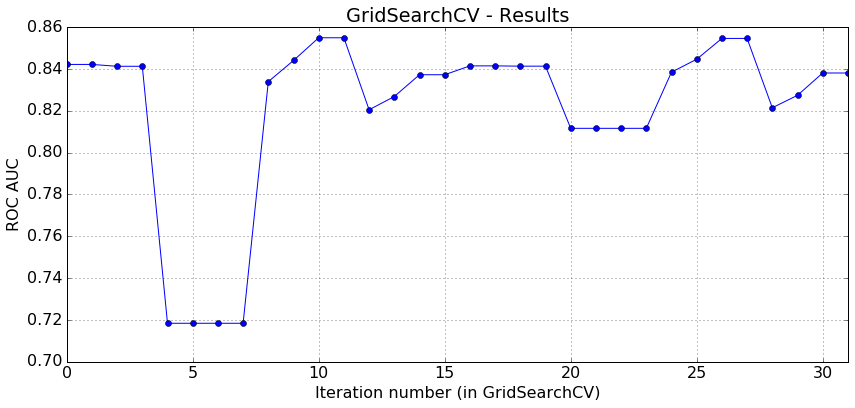

In [18]:
plt.figure(figsize=(14,6))
plt.plot(results_gs.cv_results_['mean_test_score'], 'o-')
plt.grid()
plt.xlabel('Iteration number (in GridSearchCV)')
plt.ylabel('ROC AUC')
plt.title('GridSearchCV - Results')
plt.xlim([0, len(results_gs.cv_results_['mean_test_score'])-1])
plt.show()

What are the parameters that led to the best accuracy that was achieved?

In [19]:
results_gs.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 1,
 'min_samples_leaf': 10,
 'min_samples_split': 1}

What is the best ROC AUC we got?

In [20]:
results['GridSearchCV'] = results_gs.best_score_
print('Test ROC AUC: %.4f' % results['GridSearchCV'])
print('(Test ROC AUC: %.4f - Default configuration)' % results['Default'])

Test ROC AUC: 0.8549
(Test ROC AUC: 0.7907 - Default configuration)


There is improvement here, which means that the default configuration is not the best one (as expected...).

# Tuning our Classifier: Randomized Search CV
The [**RandomizedSearchCV**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values (i.e., not all parameter values are tried out).  

Besides the distribution of the parameters (***param_distributions***) we must set the number of interations (***n_iter***) we would like the search to run, which trades-off runtime vs quality of the solution. The remaining parameters are very similar to GridSearchCV.

RandomizedSearchCV has **two main benefits** over GridSearchCV:
- A budget (number of iterations) can be chosen independent of the number of parameters and possible values.
- Adding parameters that do not influence the performance does not decrease efficiency.

In [21]:
# Distribution of the parameters (randint: discrete random variables)
param_dist = {"max_depth": randint(1, 21),
              "max_features": randint(1, 11),
              "min_samples_split": randint(1, 11),
              "min_samples_leaf": randint(1, 11),
              "criterion": ["gini", "entropy"]}

# Number of iterations to perform
n_iter = 20

# Run Randomized Search
results_rgs = RandomizedSearchCV(estimator=clf,
                                param_distributions=param_dist,
                                n_iter=n_iter,
                                cv=skfold_cv,           # use same CV folds as in GridSearchCV
                                scoring=score_metric,   # use same scoring metric as in GridSearchCV
                                random_state=1,
                                n_jobs=-1,
                                verbose=1)
results_rgs.fit(X, y)
print('Done!')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   23.6s finished


Done!


Let us evaluate the results of all runs:

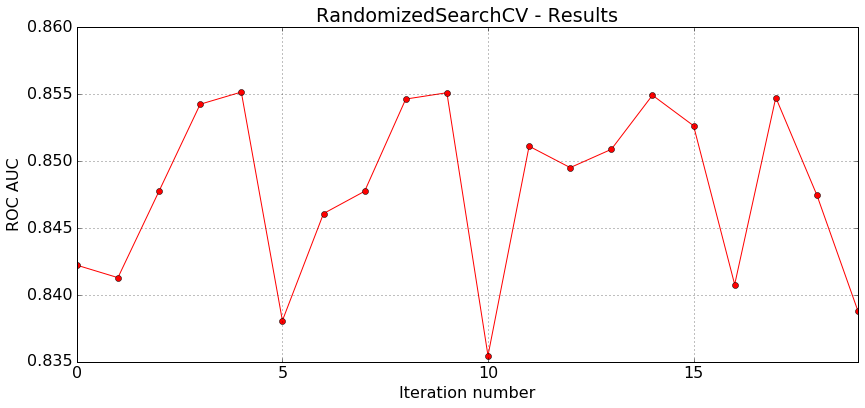

In [22]:
plt.figure(figsize=(14,6))
plt.plot(results_rgs.cv_results_['mean_test_score'], 'ro-')
plt.grid()
plt.xlabel('Iteration number')
plt.ylabel('ROC AUC')
plt.title('RandomizedSearchCV - Results')
plt.xlim([0, len(results_rgs.cv_results_['mean_test_score'])-1])
plt.show()

What are the parameters that led to the best accuracy that was achieved?

In [23]:
results_rgs.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 8,
 'min_samples_split': 1}

What is the best accuracy we got?

In [24]:
results['RandomizedGridSearchCV'] = results_rgs.best_score_
print('Test ROC AUC: %.4f' % results['RandomizedGridSearchCV'])
print('(Test ROC AUC of Grid-Search: %.4f)' % results['GridSearchCV'])

Test ROC AUC: 0.8551
(Test ROC AUC of Grid-Search: 0.8549)


There is a very slight improvement here, but was it just mere luck?

# Tuning our Classifier: Scikit-Optimize (SKOPT)
[**SKOPT**](https://scikit-optimize.github.io/) is a sequential model-based optimization. SKOPT hopefully results in equivalent or better solutions, but within less evaluations (less time consuming). It can also be reusable in various contexts besides scikit-learn (e.g., minimizing a function).

The library is built on top of NumPy, SciPy and Scikit-Learn.  

First step is to define the **objective function** we want to minimize (it accepts an array of parameters and return the function values). In our case, it is the **cross-validation negative (since we are minimizing!) ROC AUC over our dataset**, as a function of its hyperparameters. 

In [25]:
def objective_func(params):
    # Get the parameters
    max_depth, max_features, min_samples_split, min_samples_leaf, criterion = params
    # Set the parameters in the model
    clf.set_params(max_depth=max_depth, 
                     max_features=max_features,
                     min_samples_split=min_samples_split,
                     min_samples_leaf=min_samples_leaf,
                     criterion=criterion)
    # Perform CV and return the mean of the scoring values
    skfold_cv_splits = skfold_cv.split(X, y)
    return -np.mean(cross_val_score(clf,
                                    X,
                                    y, 
                                    cv=skfold_cv_splits, 
                                    n_jobs=-1, 
                                    scoring=score_metric))

Next step is to define the **bounds of the parameters** in the search space we want to explore (we could also set the starting point) and the **number of iterations**.

In [26]:
# Optimization Space (parameters and their boundaries):
space = [(1, 20),               # max_depth
         (1, 10),               # max_features 
         (1, 10),               # min_samples_split 
         (1, 10),               # min_samples_leaf 
         ('entropy', 'gini')]    # criterion

# Name of the above features
names = ['max_depth', 'max_features', 'min_samples_split', 'min_samples_leaf', 'criterion']

# Number of iterations to perform
n_calls = 15

Optimize with SKOPT! Pass the objective function (*objective_func*) defined above and the *space* with parameter boundaries.

Make use of **gp_minimize**, Bayesian optimization (sequential design strategy for global optimization of black-box functions) using Gaussian Processes (statistical model where observations occur in a continuous domain). The objective function is approximated by a Gaussian Process.

Other minimization functions exists such as *forest_minimize* (Sequential optimisation using decision trees) or *gbrt_minimize* (Sequential optimization using gradient boosted trees). 

In [27]:
results_skopt = gp_minimize(objective_func, 
                            space, 
                            verbose=True, 
                            n_calls=n_calls)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.3323
Function value obtained: -0.8498
Current minimum: -0.8498
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.2157
Function value obtained: -0.8474
Current minimum: -0.8498
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.8051
Function value obtained: -0.8444
Current minimum: -0.8498
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9917
Function value obtained: -0.8526
Current minimum: -0.8526
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.4009
Function value obtained: -0.8539
Current minimum: -0.8539
Iteration No: 6 started. 

What are the parameters that led to the best accuracy that was achieved?

In [28]:
best_params = dict(zip(names, results_skopt.x))
results['SKOPT'] = -results_skopt.fun
print(best_params)

{'max_features': 2, 'min_samples_leaf': 5, 'max_depth': 10, 'min_samples_split': 7, 'criterion': 'gini'}


Plot the convergence over iterations:

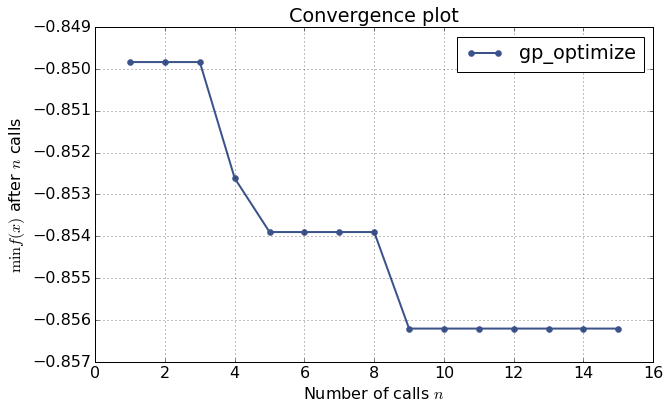

In [29]:
from skopt.plots import plot_convergence
plt.rcParams["figure.figsize"] = (10, 6)
plot_convergence(("gp_optimize", results_skopt))

# Comparing Results
Let us compare all results.

In [30]:
print('Default:                %.4f' % results['Default']) 
print('GridSearchCV:           %.4f (32 iterations)' % results['GridSearchCV']) 
print('RandomizedGridSearchCV: %.4f (20 iterations)' % results['RandomizedGridSearchCV']) 
print('SKOPT:                  %.4f (15 iterations)' % results['SKOPT']) 

Default:                0.7907
GridSearchCV:           0.8549 (32 iterations)
RandomizedGridSearchCV: 0.8551 (20 iterations)
SKOPT:                  0.8562 (15 iterations)


# To Sum Up
- Tuning hyperparameters can (significantly) increase your machine learning model performance.
- Scikit-learn provides basic hyperparameters search algorithms such as Grid-Search and Randomized Search
- Scikit-Optimize is a more advanced algorithm for hyperparameter search (among other uses) and it generally results in equivalent or better solutions, but within less evaluations (less time consuming).
- Recommendation: avoid creating your own hyperparameter optimization algorithms - build on top of existing ones